# Recommender System for Travel App

### Let's import some useful libraries

In [1]:

import numpy as np
import pickle as pkl

import os
import math
from collections import Counter
import random
import random
import enchant
import recsys
import matplotlib.pyplot as plt
#from nltk import WordNetLemmatizer, word_tokenize, bigrams, ngrams, RegexpTokenizer
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
#lemmatize = WordNetLemmatizer()
%matplotlib inline

### Now we instantiate an instance of the class recsys.  We also pick some hyperparameters. 

In [2]:
test=recsys.recsys(users=100,sites=1000,latent_features=20,dropout=0,epochs=10,max_iter=100,lr=.01,batch_size=50)


### We need some data to test this one.  Let's make some data up.

In [3]:
data=[]
users=100
sites=1000
ranked=30
for j in range(users):
    ra=np.random.choice(range(users),ranked)
    data.append(np.array([10*random.random() if (i in ra) else float('NaN') for i in range(sites)]))
data=np.array(data)

### Calling the fit method on this 'data'

In [4]:
test.fit(data)

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


### We now have a fit model.  Let's check the loss function.  The losses are stored in the recsys class, so we can just call 'test.losses' to get a list of losses for each iteration.

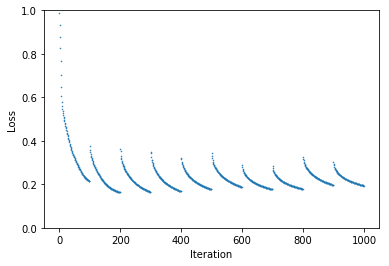

In [5]:
plt.scatter(list(range(len(test.losses))),test.losses,s=.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

### Now we can make some predictions for a new user....  Since I'm lazy, I'll just make a prediction for one of the previously seen users.  The call looks like this:

In [6]:
predictions=test.predict(data[2])

# Making Predictions w/ Real Data

Now we need to run this with some real data.  Below we have some functions to clean the data.  The data is coming from https://www.tripadvisor.com/ and https://trip.sftravel.com/.

In [5]:
#Results is a list of user rankings of various attractions in SF.  It is structured as a list of json
# like files of the form [{user1:{attraction1:rating1,attraction2:rating2,attraction3:rating3}, user2:...}]

results=[]
for k in range(100,19400,100):
    with open(f'data/file_{k}.pkl','rb') as f:
        likes=pkl.load(f)
        results.append(likes)
    
# Now we need to combine all the results above into one big dictionary.    
              
res=results[0]
for i in range(1,len(results)):
    res={**res,**results[i]}
    
with open('data/loc_info.pkl','rb') as f:
    loc_info=pkl.load(f)
    
with open('data/style_mapper.pkl','rb') as f:
    style_mapper=pkl.load(f)
    
def remove_reviews(bla):
    return [x for x in bla if 'Reviews' not in x]


In [6]:
# Here need a map which takes in 'res' and 

user_visited_places=[]
for u in res.keys():
    for place in res[u].keys():
        place_minus_sf=place[15:]
        user_visited_places.append(place_minus_sf)
        
uvp_set=set(user_visited_places)

def make_labeled_uvp(uvp_set,labeled_locations):
    labeled_uvp={}
    for pc in uvp_set:
        comp_best=0
        current_closest=None
        for sft in labeled_locations:
            comp=fuzz.ratio(pc.lower().replace('san francisco',' '),sft.lower().replace('san francisco',' '))
            if comp>comp_best:
                comp_best=comp
                current_closest=sft

        if comp_best>83:
            labeled_uvp[pc]=current_closest
    return labeled_uvp

loc_info_clean={x: remove_reviews(loc_info[x][1]) for x in loc_info.keys()}

labeled_uvp=make_labeled_uvp(uvp_set,list(loc_info_clean.keys()))

In [7]:
def condition(x):
    bad_words=['cafe', 'restaurant', 'bar', 'deli', 'diner','donald', 'panera','canteen','chophouse','saloon','eatery',\
               'dive','fast-food','coffee','canteen','pizzeria','grill','drive-in','hamburger','caffe','kitchen',\
                'taqueria','crepe','bagel','comer','bakery','steak','noodle','pizza','burger','sushi','hotel','cuisine',\
              'bakeshop','bistro','donuts','baskin robbins','ice cream','jamba juice','pollo','subs','food','soft serve',\
              'taco','ramen','shabu','jerry','holiday inn','chowder','gyros','cantina','fish','juice','taste','inn','pub',\
              'mrs. fields','cebicheria','boulangerie','le marais','nijiya','uma casa','cupcakes','chicken','resturant',\
              'sushirrito','motel','hotel','tavern','biscuit','warming','rv park','lounge','ihop','stinking','pizzetta',\
              'puccini','tortilla']
    

    return all([w not in x for w in bad_words])

In [8]:
data=config_data(res,loc_info,style_mapper)
user_profiles, matrix, reviewed_places, mpp, style_mapper = data
full_place_profiles, full_place_list, unreviewed_places = mpp
full_place_list

NameError: name 'config_data' is not defined

In [9]:
# make_matrix takes in a list of rankings of attractions as well as a dictionary (site to labels) and spits out 
# 1) an array of user preferences, 2) a list of users and 3) a list of attractions.  The only reason we need to feed
# in the dictionary is to see if there is labeled data....  

#New strategy:  Include all the sites whether or not there is a label.  Later, assign each site a vector, the vector
# being zero if unlabeled.

def make_matrix(res):
    user_list=list(res.keys())
    places=[]
    for user_key in user_list:
        for place in res[user_key].keys():
            place_minus_sf=place[15:]
            #if place_minus_sf in labeled_places:
            if condition(place.lower()):
                places.append(place)
            
    #this is the same as uvp_set above.
    places=list(set(places))


    matrix=[]
    for u in user_list:
        user_likes=[]
        for p in places:
            if p in res[u].keys():
                user_likes.append(res[u][p])
            else:
                user_likes.append(float('NaN'))
        matrix.append(user_likes)

    return np.array(matrix), user_list, places


# get_data takes in the results 'res' above and spits out a 'clean' matrix of user preferences
# as well as a list of users and places.  This is basically a cleaned version of 'make_matrix'

def get_data(res):
    
    matrix, user_list, places = make_matrix(res)
    
    good_list=[]
    for i in range(len(matrix)):
        if sum(np.nan_to_num(matrix[i],0))!=0:
            good_list.append(i)
            
    users_clean=np.array(user_list)[good_list]
    matrix_clean=matrix[good_list]
    return matrix_clean, users_clean, places

In [10]:
def make_profiles_new(matrix,loc_info_clean):
    profiles={}
    for u in range(len(matrix)):
        features_list=[]
        for i in range(len(matrix[0])):
            try:
                features_list+=int(matrix[u][i])*(loc_info_clean[places[i][15:]])
            except:
                features_list+=''

        new_features=[]
        for f in features_list:
            try:
                nf=style_mapper[f]
                if type(nf)==str:
                    new_features.append(nf)
                else:
                    new_features+=nf
            except:
                pass

        ct=Counter(new_features)
        tot=sum(ct.values())

        #res={k:10*ct[k]/tot for k in ct.keys()}
        #Use the line above if we want to normalize everything to a total of 10, else, use below.
        
        res={k:ct[k] for k in ct.keys()}
        profiles[u]=res
    return profiles


def convert_profiles_to_np(profiles,attributes=['Nature','History','Culture','Life']):
    
    #Where does matrix come from?
    np_profiles=[]
    for u in range(len(profiles)):
        user_profile=[]
        for a in attributes:
            if a in profiles[u].keys():
                user_profile.append(profiles[u][a])
            else:
                user_profile.append(0)
        np_profiles.append(user_profile)
    return np.array(np_profiles)

#Flatten is just a helper function for 'make_profiles'

def flatten(testlist):
    acc=[]
    for x in testlist:
        if type(x)==str:
            acc.append(x)
        elif type(x)==list:
            acc+=x
    return acc

In [11]:
def make_place_profile(places_clean,loc_info_clean,style_mapper):
    place_profile=[]
    for p in places_clean:
        try:
            loc_info=loc_info_clean[p]
            new_labels=[]
            for label in loc_info:

                sml=style_mapper[label]

                if type(sml)==list:
                    new_labels+=sml
                else:
                    new_labels+=[sml]
                    pass
                #print(new_labels)
            ct=Counter(new_labels)
            place_profile.append(np.array([ct['Nature'],ct['History'],ct['Culture'],ct['Life']]))
        except:
            place_profile.append(np.array([0,0,0,0]))
    return place_profile

In [12]:
def create_recsys(matrix,dropout=.1,latent_features=4,max_iter=10,lr=.001,epochs=3,temperature=1,batch_size=50):
    return recsys.recsys(matrix,len(matrix),len(matrix[0]),latent_features,dropout,max_iter,epochs,temperature,lr,batch_size=batch_size)

In [13]:
def make_place_arrays(places,loc_info_clean,style_mapper):
    
    places_clean=[x[15:] for x in places]
    unreviewed_places=[x for x in loc_info_clean.keys() if x not in places_clean and 'tour' not in x.lower()]
    reviewed_places=[x for x in loc_info_clean.keys() if x in places_clean]
    full_place_list=places_clean+unreviewed_places

    
    place_profile = make_place_profile(places_clean,loc_info_clean,style_mapper)
    unreviewed_place_profile = make_place_profile(unreviewed_places,loc_info_clean,style_mapper)
    rp = np.vstack(place_profile)
    unreviewed_places = np.vstack(unreviewed_place_profile)
    full_profiles = np.concatenate((rp,unreviewed_places),axis=0)
    return full_profiles, full_place_list, unreviewed_places

In [14]:
def config_data(res, loc_info, style_mapper):
    

    matrix, user_list, places = get_data(res)
    
    loc_info_clean={x: remove_reviews(loc_info[x][1]) for x in loc_info.keys()}
    
    user_profiles=make_profiles_new(matrix,loc_info_clean)
    
    places_clean=[x[15:] for x in places]
    padding=len([x for x in loc_info_clean.keys() if x not in places_clean and 'tour' not in x.lower()])
    
    
    zeros=np.zeros((len(matrix),padding))
    
    user_profiles=make_profiles_new(matrix,loc_info_clean)
    np_profiles=convert_profiles_to_np(user_profiles)
    new_matrix=np.concatenate((np_profiles,matrix,zeros),axis=1)
    
    mpp = make_place_arrays(places,loc_info_clean,style_mapper)
    
    return user_profiles, new_matrix, places, mpp, style_mapper

In [15]:
data=config_data(res,loc_info,style_mapper)
user_profiles, matrix, reviewed_places, mpp, style_mapper = data
full_place_profiles, full_place_list, unreviewed_places = mpp
full_place_list

['Giorgio Armani',
 'The Coastal Trail',
 'Gibson',
 'Chelsea Place',
 'Gino and Carlo',
 "Ferry Plaza Farmer's Market",
 'San Francisco Hybrid Bike Rental',
 'Queen Anne Victorians',
 'Golden Gate Perk',
 'Black Hammer Brewing',
 'Black Cat',
 'San Francisco Bay Sunset Catamaran Cruise',
 'Redwood Room',
 'Creations Dessert House',
 'After Osha',
 'EscapeSF',
 "Sodini's",
 'Images of the North',
 'Jack Early Park',
 '7 Mission',
 'Piccino',
 'Zzan',
 'Hopwater Distribution',
 '21 Club',
 'Coco Bang',
 'Market & Rye',
 'Gio Gelati',
 'Eight Tables by George Chen',
 'Fermentation Lab',
 'San Francisco Maritime National Historical Park',
 'Ragazza',
 'Napa & Sonoma Valley Wine Tour',
 'Blackwood',
 'The Baked Bear',
 'Pier 7',
 'Nipponya',
 'Ghirardelli-On-The-Go',
 'Haight Ashbury Flower Power Walking Tour',
 'noori pakistani',
 'Pho 2000',
 'Bluestem Brasserie',
 'Izakaya Ninja',
 'Pacific Tradewinds Hostel',
 'SFJazz Center',
 'The Bell Tower',
 'China Live',
 'Lokma',
 'W San Francis

In [16]:
len(matrix[0]), len(full_place_profiles)

(2272, 2268)

In [36]:
with open('model/full_place_list.pkl','wb') as f:
    pkl.dump(full_place_list,f)
    
    
with open('model/place_profiles.pkl','wb') as f:
    pkl.dump(full_place_profiles,f)
    


In [20]:
full_place_profiles.shape

(2268, 4)

In [24]:
nature=full_place_profiles[:,0]
history=full_place_profiles[:,1]
culture=full_place_profiles[:,2]
life=full_place_profiles[:,3]

In [87]:
preferences=[3,1,4,-5]
new_user_preferences=(10/sum(np.abs(preferences)))*np.array(preferences)
offset=np.array([sum(new_user_preferences*x) for x in full_place_profiles])/4

In [88]:
initialization=np.zeros(len(full_place_profiles))
new_user=np.concatenate((new_user_preferences,initialization),axis=0)
predictions_raw=test_real.predict(new_user)
nn_predictions=predictions_raw.detach().numpy()

In [89]:
full_place_list[list(nn_predictions).index(max(nn_predictions))]

'Macondray Lane'

In [41]:
os.getcwd()


'/Users/williamcottrell72/MyGit/Kodak'

In [35]:
with open('data/processed_data.pkl','wb') as f:
    pkl.dump(data,f)

# with open('data/processed_data.pkl','rb') as f:
#     processed_data=pkl.load(f)

In [17]:
test_real=create_recsys(data[1],max_iter=200,lr=.01,epochs=8,batch_size=200,latent_features=10)

In [18]:
data[1].shape

(10812, 2272)

In [19]:
test_real.fit()

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8


In [29]:
sample_indices=np.random.choice(range(len(data[1][0])),17,replace=False)
sample=data[1][sample_indices]

In [30]:
test_real.forward(sample)

tensor([[ 3.4386e-08, -6.3603e-09,  3.3950e-08,  ..., -4.0861e-08,
         -4.4710e-09, -9.9749e-09],
        [ 2.6259e-08,  5.8133e-08,  4.4974e-08,  ..., -4.2803e-08,
         -1.3899e-08,  3.8761e-08],
        [ 5.0430e-08,  5.4660e-08,  8.7439e-09,  ..., -1.0261e-07,
         -1.2849e-08,  7.2571e-08],
        ...,
        [-9.0313e-10,  3.4373e-10,  6.1498e-08,  ...,  6.1823e-08,
          4.4005e-09,  6.4246e-08],
        [ 4.0223e-08,  9.8449e-09,  8.6489e-08,  ...,  2.9566e-08,
          3.0022e-08,  3.8597e-08],
        [-1.2509e-09,  2.7384e-08, -2.8282e-08,  ..., -5.3728e-08,
          3.9183e-08,  1.3495e-08]], grad_fn=<ThAddmmBackward>)

In [31]:
with open('model/model.pkl','wb') as f:
    pkl.dump(test_real,f)

# with open('model/model.pkl','rb') as f:
#     test_real=pkl.load(f)

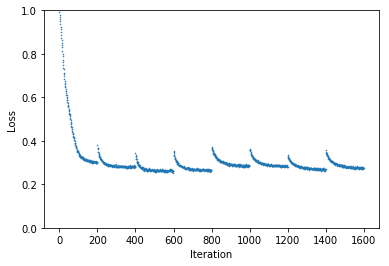

In [38]:
plt.scatter(list(range(len(test_real.losses))),test_real.losses,s=.3)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.show()

In [39]:
# Predictions are in the full space, including the rated and unrated attractions

def preferences_to_placescores(preferences,weight,num_results=10,fpp=full_place_profiles):
  
    
    
    new_user_preferences=(10/sum(preferences))*np.array(preferences)
    
    
    initialization=np.zeros(len(fpp))

    #Finally, we combine the preferences with the initialization to represent the new user as a row.

    new_user=np.concatenate((new_user_preferences,initialization),axis=0)


    #Let's figure out what the user likes!
    predictions_raw=test_real.predict(new_user)
    
    predictions=predictions_raw.detach().numpy()[len(preferences):]

    
    
    offset=[sum(new_user_preferences*x) for x in fpp]

    final_predictions=predictions+weight*np.array(offset)
    place_prediction=sorted(list(enumerate(final_predictions)),key=lambda x: x[1],reverse=True)[:num_results]
    return [[full_place_list[x[0]],x[1]] for x in place_prediction]
    

In [40]:
preferences_to_placescores([1,2,3,4],1,10,full_place_profiles)

[['War Memorial Opera House', 18.003381989896297],
 ['Presidio Chapel', 17.0000015499254],
 ['Chinese United Methodist Church', 16.999999973750104],
 ['The Gregangelo Museum', 16.9999999212084],
 ['The San Francisco Mead Company', 16.000000170980698],
 ['500 Capp Street Foundation', 15.999999980141126],
 ['San Francisco Art Exchange', 15.999999976091935],
 ['The Embarcadero', 15.999999945461283],
 ['Ghirardelli Square', 15.076905012130737],
 ['Ferry Building Marketplace', 15.044763803482056]]

In [19]:
full_profiles, full_place_list, urp = mpp
zeros=np.zeros((len(matrix),len(urp)))

In [35]:
new_user_preferences=(10/sum(preferences))*np.array(preferences)

NameError: name 'preferences' is not defined

In [56]:
initialization=np.zeros(len(data[1][0])-len(preferences))

#Finally, we combine the preferences with the initialization to represent the new user as a row.

new_user=np.concatenate((new_user_preferences,initialization),axis=0)
len(new_user)

2359

In [68]:
data[1].shape

(10836, 2359)

In [66]:
new_user.reshape(1,-1).shape

(1, 2359)

In [21]:
predictions_raw=test_real.predict(new_user.reshape(1,-1))

NameError: name 'test_real' is not defined

In [43]:
# ['Nature','History','Culture','Life']
preferences=[0,1,0,0]
preferences_to_placescores(preferences,num_results=20,weight=.01)

RuntimeError: size mismatch, m1: [1 x 2359], m2: [3679 x 10] at /Users/soumith/miniconda2/conda-bld/pytorch_1532623076075/work/aten/src/TH/generic/THTensorMath.cpp:2070

In [231]:

# full_predictions=test_real.predict(new_matrix)
# full_predictions2=full_predictions[:,4:].detach().numpy()
# averages=[np.mean(full_predictions2[:,i]) for i in range(len(full_profiles))]
# stds=[np.std(full_predictions2[:,i]) for i in range(len(full_profiles))]